# Max Ensemble Low FPR

In [18]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

COLUMNWIDTH = 241.14749
COLUMNWIDTH_INCH = 0.01384 * COLUMNWIDTH
TEXTWIDTH = 506.295
TEXTWIDTH_INCH = 0.01384 * TEXTWIDTH

sns.set_context("paper")

# set fontsize
plt.rc('xtick', labelsize=7)
plt.rc('ytick', labelsize=7)
plt.rc('legend', fontsize=7)
plt.rc('font', size=7)       
plt.rc('axes', titlesize=8)    
plt.rc('axes', labelsize=8)

# modify this to set up directory:
DATA_DIR = "data"


# intersection, union, majority_vote
ensemble_method = "union"

mia_name_mapping = {"losstraj": "losstraj", "shokri": "Class-NN", "yeom": "LOSS", "lira": "LiRA", "aug": "aug", "calibration": "calibrated-loss", "reference": "reference"}
mia_color_mapping = {"losstraj": '#1f77b4', "shokri": '#ff7f0e', "yeom": '#2ca02c', "lira": '#d62728', "aug": '#9467bd', "calibration": '#8c564b', "reference": '#e377c2'}


1. Read the dataset

In [19]:
import os
import torch
import numpy as np
import pickle
from typing import List, Tuple, Dict

import sys
sys.path.append("../../../")
sys.path.append("../../")
sys.path.append("../")
from miae.eval_methods.experiment import ExperimentSet, TargetDataset
from miae.eval_methods.prediction import Predictions
from experiment.mia_comp.datasets import CINIC10

datasets = ["cifar10", "cifar100", "cinic10"]
model = "resnet56"
output_dir = f"{DATA_DIR}/miae_standard_exp/ensemble_process_tables"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

target_datasets = []
for ds in datasets:
    target_datasets.append(TargetDataset.from_dir(ds, f"{DATA_DIR}/miae_standard_exp/target/{ds}"))

2. load the shadow attacks predictions and regular attack predictions

In [20]:
seeds = [0, 1, 2, 3, 4, 5]
fpr = 0.01
attack_list = ["losstraj", "lira", "calibration", "reference"] # these 4 attack has gained their precision for ensemble
pred_path = f"{DATA_DIR}/miae_standard_exp"

    
experiment_dict = {}
for ds in target_datasets:
    experiment_dict[ds.dataset_name] = ExperimentSet.from_dir(ds, attack_list, pred_path, seeds, model, fpr_to_adjust=fpr)

3. calculate precision for single-instance, multi-instance, and ensemble. All at FPR = 0.01

In [21]:
import itertools
"""-------------- Single instance ----------------"""
single_instance_precision_dict = dict()
single_instance_pred_dict = dict()
for ds in target_datasets:
    single_instance_precision_dict[ds.dataset_name] = dict()
    single_instance_pred_dict[ds.dataset_name] = dict()
    for attack in attack_list:
        current_attack_pred = experiment_dict[ds.dataset_name].retrieve_preds(attack, 0)
        single_instance_pred_dict[ds.dataset_name][attack] = current_attack_pred
        single_instance_precision_dict[ds.dataset_name][attack] = current_attack_pred.confusion_matrix_precision()

"""-------------- Multi instances ----------------"""
from typing import List

"""
    Apply the specified operation (intersection, union, or majority vote) to the given list of Predictions objects.
"""

def apply_operation(prediction_list: List[Predictions], operation: str = 'intersection') -> Predictions:
   
    if not prediction_list:
        raise ValueError("The prediction list is empty.")
   
    pred_arr_list = [pred.pred_arr for pred in prediction_list]

    if operation == 'intersection':
        # apply logical AND (intersection)
        result_pred = np.ones_like(pred_arr_list[0])
        for arr in pred_arr_list:
            result_pred = np.logical_and(result_pred, arr)
    elif operation == 'union':
        # apply logical OR (union)
        result_pred = np.zeros_like(pred_arr_list[0])
        for arr in pred_arr_list:
            result_pred = np.logical_or(result_pred, arr)
    elif operation == 'majority_vote':
        # apply the majority vote threshold
        vote_count = np.zeros_like(pred_arr_list[0], dtype=int)
        for arr in pred_arr_list:
            vote_count += arr
        result_pred = vote_count >= (len(prediction_list) / 2)
    else:
        raise ValueError(f"Unsupported operation: {operation}")
   
    return Predictions(result_pred, prediction_list[0].ground_truth_arr, f"{operation}_multi_instance")


multi_instance_precision_dict = dict()
multi_instance_pred_dict = dict()


for ds in target_datasets:
    multi_instance_precision_dict[ds.dataset_name] = dict()
    multi_instance_pred_dict[ds.dataset_name] = dict()

    # For each attack in the attack list, apply the selected operation
    for attack in attack_list:
        
        multi_instance_preds_list = [experiment_dict[ds.dataset_name].retrieve_preds(attack, seed) for seed in seeds]
       
        """ ----- Choose the operation : 'intersection', 'union', or 'majority_vote'------ """
        
        operation = ensemble_method 

        # Apply the chosen operation
        operation_pred = apply_operation(multi_instance_preds_list, operation=operation)
        multi_instance_pred_dict[ds.dataset_name][attack] = operation_pred
        multi_instance_precision_dict[ds.dataset_name][attack] = operation_pred.confusion_matrix_precision()


"""-------------- Multi-attack Ensemble----------------"""
def max_ensemble(pred_dict: Dict[str, Predictions], gt, attack_name_list) -> List[Predictions]:
    """
    Max ensemble predictions for all attack combinations.
    """

    def find_combinations_index(num_elements: int):
        """
        Find the list of all combinations of indices, including non-consecutive combinations.
        """
        lst = list(range(num_elements))
        combinations = []
        
        # Use itertools to generate all combinations of all lengths
        for r in range(2, num_elements + 1): 
            combinations.extend(itertools.combinations(lst, r))
        
        return [list(comb) for comb in combinations]
        

    combination_idx_list = find_combinations_index(len(pred_dict.keys()))
    
    result_pred_list = []
    for comb_idx in combination_idx_list:
        pred_union = np.zeros_like(pred_dict[attack_name_list[0]].pred_arr)
        attack_name_union = []
        for idx in comb_idx: # Do "OR" operation to find the union incrementally
            attack_name_union.append(attack_name_list[idx])
            pred_union = np.logical_or(pred_union, pred_dict[attack_name_list[idx]].pred_arr)
        result_pred_name = "_".join(sorted(attack_name_union)) + "max-ensemble"
        result_pred_list.append(Predictions(pred_union, gt, result_pred_name))
    return result_pred_list
 
multi_attack_ensemble_precision_dict = dict()
multi_attack_pred_dict = dict()

for ds in target_datasets:
    gt = ds.membership
    ensemble_predictions = max_ensemble(multi_instance_pred_dict[ds.dataset_name], gt, attack_list)
    multi_attack_pred_dict[ds.dataset_name] = dict()
    multi_attack_ensemble_precision_dict[ds.dataset_name] = dict()
    for pred in ensemble_predictions:
        multi_attack_pred_dict[ds.dataset_name][pred.name] = pred
        multi_attack_ensemble_precision_dict[ds.dataset_name][pred.name] = pred.confusion_matrix_precision()


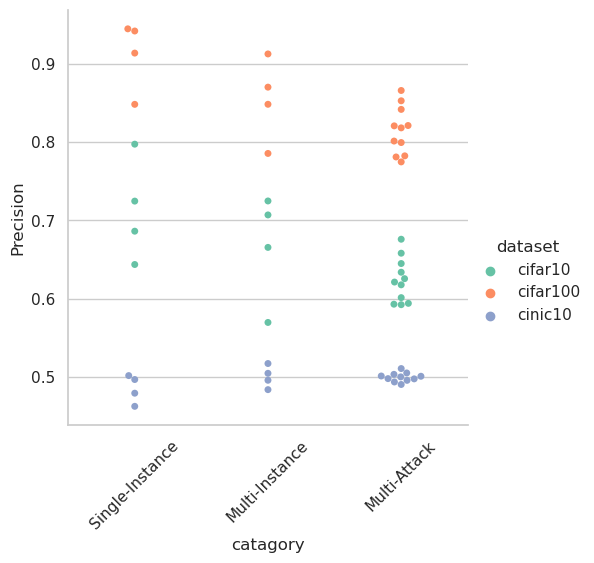

In [22]:
# plot precision with catagorical scatter plot
import pandas as pd

def catagoical_scatter_plot(data: List[List[Dict[str, float]]], x_labels: List[str], 
                            ds: List, save_dir: str):
    """
    plot a catagorical scatter plot with hue as the ensemble level

    data: a list of precision dict
    x_labels: the x-axis labels (as catagories)
    ds: the dataset of the experiment
    save_dir: the directory to save the plot
    """


    x = []
    y = []
    ds_hue = []
    for ds_idx in range(len(ds)):
        for i, precision_dict in enumerate(data[ds_idx]):
            for _, precision in precision_dict.items():
                x.append(x_labels[i])
                y.append(precision)
                ds_hue.append(ds[ds_idx])

    df = pd.DataFrame({"catagory": x, "Precision": y, "dataset": ds_hue})
    sns.set_theme(style="whitegrid")
    ax = sns.catplot(x="catagory", y="Precision", kind="swarm", hue="dataset", palette="Set2", data=df)
    ax.set_xticklabels(rotation=45)
    plt.savefig(save_dir, format="pdf", bbox_inches='tight')

# plot the precision for each dataset
data_to_plot = []
for ds in datasets:
    data_to_plot.append([single_instance_precision_dict[ds], multi_instance_precision_dict[ds], multi_attack_ensemble_precision_dict[ds]])
    
x_labels = ["Single-Instance", "Multi-Instance", "Multi-Attack"]
save_dir = os.path.join(output_dir, f"precision_catagorical_scatter.pdf")
catagoical_scatter_plot(data_to_plot, x_labels, datasets, save_dir)

4. A spread sheet to compare the results

In [23]:
import pandas as pd


list_of_stats = []
ensemble_type = ["single_instance", "multi_instance", "multi_attack"]
keys_to_save = ["attack name", "ensemble_type", "dataset", "precision", "num_tp", "tpr", "fpr", "accuracy"]
for ds in datasets:
    for type_idx, pred_dict in enumerate([single_instance_pred_dict, multi_instance_pred_dict, multi_attack_pred_dict]):
        for attack_name, pred in pred_dict[ds].items():
            ensemble_type_name = ensemble_type[type_idx]
            precision = pred.confusion_matrix_precision()
            tpr = pred.compute_tpr()
            fpr = pred.compute_fpr()
            num_tp = len(pred.get_tp())
            accuracy = pred.accuracy()
            stat = zip(keys_to_save, [attack_name, ensemble_type_name, ds, precision, num_tp, tpr, fpr, accuracy])
            list_of_stats.append(dict(stat))

df = pd.DataFrame(list_of_stats)
df.to_csv(os.path.join(output_dir, "ensemble_stats.csv"), index=False)

In [24]:
# sub csv for each dataset
for ds in datasets:
    print()
    print(ds, ":")
    curr_data = df[df["dataset"] == ds]
    for ensemble_type in ["single_instance", "multi_instance", "multi_attack"]:
        print(ensemble_type, ":")
        curr_data_type = curr_data[curr_data["ensemble_type"] == ensemble_type]
        print("tpr \t fpr \t precision \t num_tp")
        for idx, row in curr_data_type.iterrows():
            print(format(row["tpr"], ".2e"), "\t", 
                  format(row["fpr"], ".2e"), "\t",
                  format(row["precision"], ".2f"), "\t", 
                  format(row["num_tp"]), "\t", row["attack name"])
    


cifar10 :
single_instance :
tpr 	 fpr 	 precision 	 num_tp
2.17e-02 	 9.93e-03 	 0.69 	 326 	 losstraj
1.81e-02 	 1.00e-02 	 0.64 	 271 	 lira
2.63e-02 	 1.00e-02 	 0.72 	 395 	 calibration
3.94e-02 	 1.00e-02 	 0.80 	 591 	 reference
multi_instance :
tpr 	 fpr 	 precision 	 num_tp
1.05e-01 	 4.35e-02 	 0.71 	 1574 	 losstraj
6.87e-02 	 5.19e-02 	 0.57 	 1031 	 lira
9.53e-02 	 4.79e-02 	 0.67 	 1429 	 calibration
1.08e-01 	 4.10e-02 	 0.72 	 1621 	 reference
multi_attack :
tpr 	 fpr 	 precision 	 num_tp
1.54e-01 	 9.38e-02 	 0.62 	 2308 	 lira_losstrajmax-ensemble
1.45e-01 	 7.99e-02 	 0.64 	 2178 	 calibration_losstrajmax-ensemble
1.69e-01 	 8.08e-02 	 0.68 	 2529 	 losstraj_referencemax-ensemble
1.43e-01 	 9.79e-02 	 0.59 	 2140 	 calibration_liramax-ensemble
1.48e-01 	 8.87e-02 	 0.63 	 2224 	 lira_referencemax-ensemble
1.60e-01 	 8.30e-02 	 0.66 	 2397 	 calibration_referencemax-ensemble
1.89e-01 	 1.29e-01 	 0.59 	 2830 	 calibration_lira_losstrajmax-ensemble
2.06e-01 	 1.27e-01 

In [25]:
# prepare a csv for the table
table_path = os.path.join(output_dir, "building_latex_table")
if not os.path.exists(table_path):
    os.makedirs(table_path)
colums_to_save = ["method", "calibration", "reference", "lira", "losstraj", "cifar10TPR", "cifar100TPR","cinic10TPR", "cifar10FPR", "cifar100FPR", "cinic10FPR", "cifar10Precision", "cifar100Precision", "cinic10Precision", "cifar10NumTP", "cifar100NumTP", "cinic10NumTP"]
attack_for_csv = colums_to_save[1:5]

# new dictionary to build the new csv
def get_key(method, attack_table):
    """all inputs are string to format a key"""
    calibration, reference, lira, losstraj = attack_table
    return method + calibration + reference + lira + losstraj

def extract_attacks(string, attack_list):
    ret_list = []
    for a in attack_list:
        ret_list.append(str(a in string))
    return ret_list    

csv_dict = {}
csv_list = [] # each element is a row for the csv

for ds in ["cifar10", "cifar100", "cinic10"]:
    curr_data = df[df["dataset"] == ds]
    for ensemble_type in ["single_instance", "multi_instance", "multi_attack"]:
        curr_data_type = curr_data[curr_data["ensemble_type"] == ensemble_type]
        for idx, row in curr_data_type.iterrows(): 
            key = get_key(ensemble_type, extract_attacks(row["attack name"], attack_for_csv))
            if ds == "cifar10":
                csv_dict[key] = [None]*len(colums_to_save)
                csv_dict[key][0] = ensemble_type
                csv_dict[key][1], csv_dict[key][2], csv_dict[key][3], csv_dict[key][4] = extract_attacks(row["attack name"], attack_for_csv)
                csv_dict[key][5] = format(row["tpr"]*100, ".2f")
                csv_dict[key][8] = format(row["fpr"], ".2e")
                csv_dict[key][11] = format(row["precision"]*100, ".2f")
                csv_dict[key][14] = str(row["num_tp"])
            if ds == "cifar100":
                csv_dict[key][6] = format(row["tpr"]*100, ".2f")
                csv_dict[key][9] = format(row["fpr"], ".2e")
                csv_dict[key][12] = format(row["precision"]*100, ".2f")
                csv_dict[key][15] = str(row["num_tp"])

            if ds == "cinic10":
                csv_dict[key][7] = format(row["tpr"]*100, ".2f")
                csv_dict[key][10] = format(row["fpr"], ".2e")
                csv_dict[key][13] = format(row["precision"]*100, ".2f")
                csv_dict[key][16] = str(row["num_tp"])
                # by now the row is complete, we can add it to the csv_dict
                csv_list.append(csv_dict[key])

# write the csv
fn = os.path.join(table_path, "ensemble_table.csv")
with open(fn, "w") as f:
    f.write(",".join(colums_to_save) + "\n")
    for row in csv_list:
        f.write(",".join(row) + "\n")

# write the latex table
fn = os.path.join(table_path, "ensemble_table.txt")
string_builder = ""
for row in csv_list:
    if row[0] == "single_instance":
        string_builder += "Single-instance"
    elif row[0] == "multi_instance":
        string_builder += "Multi-instance"
    else:
        string_builder += "Multi-attack"
    string_builder += "&\CIRCLE" if row[1] == "True" else "&\Circle" # calibration
    string_builder += "&\CIRCLE" if row[2] == "True" else "&\Circle" # reference
    string_builder += "&\CIRCLE" if row[3] == "True" else "&\Circle" # lira
    string_builder += "&\CIRCLE" if row[4] == "True" else "&\Circle" # losstraj
    for i in range(5, len(row)-2):
        string_builder += " & " + row[i] + "\%" if i in [5, 6, 7, 11, 12, 13] else " & " + row[i]
    for i in range(len(row)-2, len(row)):
        string_builder += " & " + row[i]
    string_builder += " \\\\\n"
with open(fn, "w") as f:
    f.write(string_builder)

print("The table is saved at: ", fn)

The table is saved at:  /home/data/wangz56/miae_standard_exp/ensemble_process_tables/building_latex_table/ensemble_table.txt
